# Tonti Diagram Elastic Beam Deflection Demo
This notebook demonstrates an example of the current interface for the definition and execution of Tonti diagrams.

In [1]:
#== Import required libraries ==#
using Catlab.Graphs
using Catlab.Graphics
using Catlab.CategoricalAlgebra
using CombinatorialSpaces
using Distributions
using CairoMakie
using DifferentialEquations
using AlgebraicDynamics.TontiDiagrams

In [2]:
# helper function for setting initial conditions
function gen_form(s::EmbeddedDeltaSet2D, f::Function)
  map(f, point(s))
end

gen_form (generic function with 1 method)

## Import a mesh for the physics
We begin by importing a mesh which the DEC operators will be defined on. Our goal is to have application of a physics to a mesh be the last step (after defining the physics in a Tonti diagram).

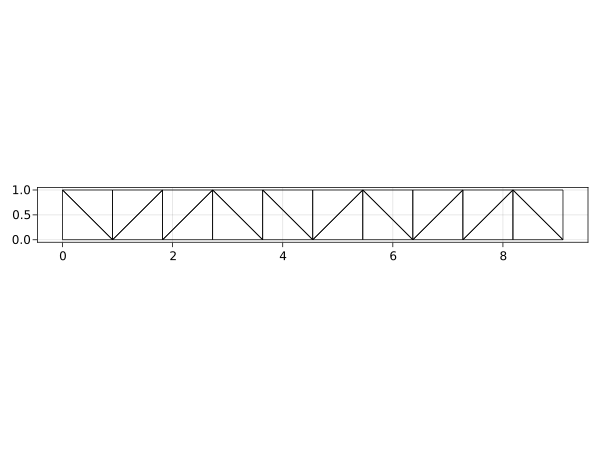

In [3]:
s = EmbeddedDeltaSet2D("../notebooks/truss_v1.obj");
sp = Space(s)
sd = sp.sd;
figure, axis, ob = wireframe(s)
axis.aspect = AxisAspect(10/1)
figure

## Define boundaries
Currently boundaries are obtained through calculating all boundary edges, then filtering by location for appropriate specific boundaries. This will be replaced with a connected components algorithm, which can present each individual boundary automatically.

In [31]:

# Get boundary masks for BCs #
boundary_e = findall(x -> x != 0, boundary(Val{2},s) * fill(1,ntriangles(s))) # mesh edges
boundary_v = unique(vcat(s[boundary_e,:src],s[boundary_e,:tgt])) # mesh edge vertices

# Get 
left = filter(x->all((0.0,0.0,0.0) .<= s[x,:point] .<= (0,1.0,0.0)), boundary_v)
force_v = [22]

[1, 2, 3, 4, 6, 5, 8, 7, 9, 10, 11, 12, 13, 14, 15, 16, 18, 17, 20, 21, 19, 22][1, 2]

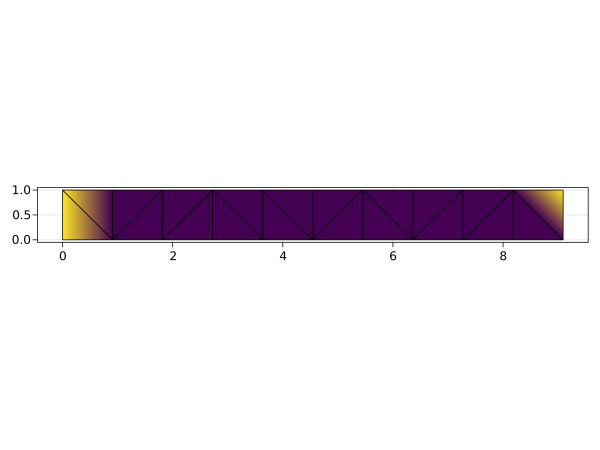

In [37]:
boundary_indices = [1, 2, 22]
colors = zeros(nv(s)) # Generate a 0-form (array with the same number of elements as there are points
colors[boundary_indices] .= 1 # "highlight" the boundary vertices
fig, ax, ob = mesh(s, color=colors)
wireframe!(s)
ax.aspect = AxisAspect(10/1)
fig

## Initialize the Tonti diagram
We begin by initializing the ACSet which will store our Tonti diagram.

In [71]:
tdx = TontiDiagram();
tdy = TontiDiagram();

## Define the physics

In [72]:
# Define the physical constants
F_load = 9 * 10^6 # prescribed free end point force (N)
E = 5 * 10^6 # Elastic Young's modulus (N/m^2)
A = 1; # cross-sectional area (m^2)
x0 = 10; # original length (m)
d = 0.025

# Define variables along with their dimensionality (var_name, dimensionality, complex (primal vs. dual))
add_variables!(tdx, (:Δx,0,true),(:ϵx,1,true),(:σx,1,false), (:fx,2,false), (:vx, 0, true))
add_variables!(tdy, (:Δy,0,true),(:ϵy,1,true),(:σy,1,false), (:fy,2,false), (:vy, 0, true))

# Add spatial and temporal derivative relationships
add_derivatives!(tdx, sp, :Δx=>:ϵx)
add_derivatives!(tdy, sp, :Δy=>:ϵy)
add_derivatives!(tdx, sp, :σx=>:fx)
add_derivatives!(tdy, sp, :σy=>:fy)
add_time_dep!(tdx, :Δx, :vx)
add_time_dep!(tdy, :Δy, :vy)

# Merge the two diagrams to allow radial Hooke's law to be defined
td = disjoint_union(tdx, tdy);

# Dual-primal mesh relationships
add_transition!(td, [:ϵx], (σx,ϵx) -> (σx.=E*sp.hodge[1,2]*ϵx) , [:σx])
add_transition!(td, [:ϵy], (σy,ϵy) -> (σy.=E*sp.hodge[1,2]*ϵy) , [:σy])
add_transition!(td, [:fx], (vx,fx) -> (vx.=d*sp.hodge[2,3]*(fx)), [:vx])
add_transition!(td, [:fy], (vx,fx) -> (vy.=d*sp.hodge[2,3]*(fy)), [:vy])

# Boundary conditions for a fixed-free configuration
add_bc!(td, :Δx, Δx->(Δx[vcat(left)].=0))
add_bc!(td, :fy, (fy)->(fy[force_v] .+= F_load))

2

## Generate the simulator
This vectorfield object can be passed to DifferentialEquations.jl to be solved

In [73]:
data, sim = vectorfield(td, sp);
data

Dict{Symbol, Tuple{Int64, Int64}} with 2 entries:
  :Δx => (1, 22)
  :Δy => (23, 44)

## Define our initial conditions

In [10]:
c_range = range(data[:C]...,step=1)
v_range = range(data[:v]...,step=1)
p_range = range(data[:p]...,step=1)
u = zeros(Float64,maximum(last.(values(data))))
c = gen_form(s, x->x[0])
p = gen_form(s, x->0.0);

In [11]:
velocity(x) = begin
  amp = 2.0
  amp * Point{3,Float64}(-1,0,0)
end
v = ♭(sd, DualVectorField(velocity.(sd[triangle_center(sd),:dual_point])));

In [12]:
u[c_range] .= c
u[v_range] .= v
u[p_range] .= p;

## Solve the system

In [13]:
tspan=(0.0,25.0)
prob = ODEProblem(sim, u, tspan)
sol = solve(prob, Tsit5());

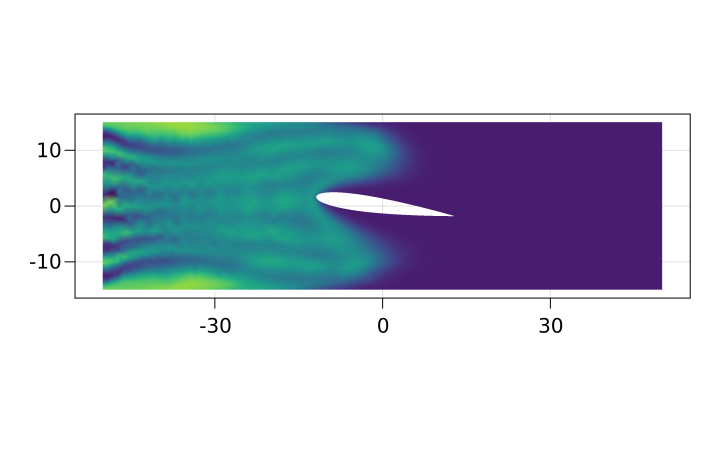

In [14]:
times = range(0,tspan[2], length=150)
colors = [sol(t)[c_range] for t in times]
figure, axis, scatter_thing = mesh(s, color=colors[75],
                                   colorrange=(minimum(vcat(colors...)),
                                               maximum(vcat(colors...))))
axis.aspect = AxisAspect(10/1)
figure

In [15]:
framerate = 30
record(figure, "flow_conc.gif", collect(1:length(collect(times))); framerate = framerate) do i
  scatter_thing.color = colors[i]
end

"flow_conc.gif"